shape del df --> (729, 8)
columnas del df --> Index(['fecha', 'pm10', 'no2', 'intensidad', 'PCA1', 'PCA2', 'PCA3', 'PCA4'], dtype='object')
Nulos del df --> fecha         0
pm10          0
no2           0
intensidad    0
PCA1          0
PCA2          0
PCA3          0
PCA4          0
dtype: int64
Nulos del df --> fecha         0
pm10          0
no2           0
intensidad    0
PCA1          0
PCA2          0
PCA3          0
PCA4          0
dtype: int64


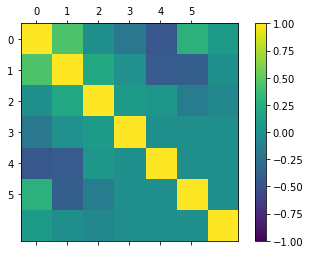

In [1]:
import numpy
import pandas as pd
from numpy import arange
from matplotlib import pyplot
from pandas import read_csv
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer



dfMergeMadrid = pd.read_csv('../../../../Datos_Mergeados/Madrid/DatosMergeadosMadrid_ConSeleccionCaract_PCA.csv' , delimiter=',', na_values='?')

print("shape del df -->",dfMergeMadrid.shape)
print("columnas del df -->",dfMergeMadrid.columns)

#dfMergeMadrid.drop('indicativo', axis='columns', inplace=True)
#dfMergeMadrid.drop('fecha', axis='columns', inplace=True)


#print("Las columnas del df son: --> ",dfMergeMadrid.columns)
#print("Este es el encabezado -->",dfMergeMadrid.head())
print("Nulos del df -->",dfMergeMadrid.isnull().sum())

print("Nulos del df -->",dfMergeMadrid.isnull().sum())



### matriz de correlación
fig = pyplot.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(dfMergeMadrid.corr(), vmin=-1, vmax=1, interpolation='none')
fig.colorbar(cax)
ticks = arange(0,6,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
pyplot.show()

Test puntual de algoritmos: Línea base

En primera instancia, no tenemos idea de qué algoritmos funcionarán bien en este problema. Una intuición inicial sugiere que los algoritmos de regresión como Regresión lineal y ElasticNet pueden funcionar bien. También es posible que los árboles de decisión e incluso SVM lo hagan bien. No tengo idea. Diseñemos nuestra selección de prueba.

Vamos a utilizar 10 veces la validación cruzada. El conjunto de datos no es demasiado pequeño y esta es una buena configuración para la selección de la prueba estándar. Evaluaremos los algoritmos utilizando la métrica de error cuadrático medio (MSE). MSE dará una idea general de cuán equivocadas son todas las predicciones (0 es perfecto).

Creamos una línea de base de rendimiento en este problema y revisamos una serie de algoritmos diferentes. Seleccionaremos un conjunto de algoritmos diferentes capaces de trabajar en este problema de regresión. Los seis algoritmos seleccionados son:

    Algoritmos lineales: Regresión lineal (LR), Regresión de lasso (LASSO) y ElasticNet (EN).
    Algoritmos no lineales: árboles de clasificación y regresión (CART), Regresión de vectores de soporte (SVR) y k-vecinos más cercanos (KNN).



# Evaluación de los algoritmos
Dataset de validación de división (Split-out)

Dejaremos 80-20, preparado para CV de 10-folds

In [2]:
X = dfMergeMadrid.iloc[:,2:7]
Y = dfMergeMadrid['pm10']
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

### Test puntual de algoritmos: Línea base
Vamos a utilizar 10 veces la validación cruzada. El conjunto de datos no es demasiado pequeño y esta es una buena configuración para la selección de la prueba estándar. Evaluaremos los algoritmos utilizando la métrica de **error cuadrático medio (MSE)**. MSE dará una idea general de cuán equivocadas son todas las predicciones (0 es perfecto).

In [3]:
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error'

## c) Algoritmos de control/Test puntual. Usaremos 6 tipos:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR(gamma='scale')))

In [4]:
### evaluamos cada modelo por turnos
results = []
names = []
for name, model in models:
	kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

LR: -48.837205 (7.192918)
LASSO: -48.878291 (7.514690)
EN: -48.861359 (7.443331)
KNN: -54.014855 (8.335066)
CART: -68.203141 (10.356968)
SVR: -91.892532 (17.619008)


### - Comparación los algoritmos
Habrá que mirar la distribución de puntajes en todos los *folds* de validación cruzada por cada algoritmo.

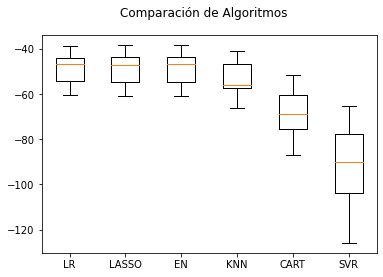

In [5]:
## d) Comparación los algoritmos, y escogemos el más preciso, que en este caso será SVR
fig = pyplot.figure()
fig.suptitle('Comparación de Algoritmos')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()


### Estandarización del dataset
Con la sospecha de que las diferentes escalas de los datos en bruto pueden afectar negativamente la capacidad de predicción de algunos de los algoritmos, evaluamos estos mismos algoritmos con una copia estandarizada del conjunto de datos. 

Es en este punto en donde los datos se transforman de tal manera que cada atributo tiene un **valor medio de 0 y una desviación estándar de 1**. 

También debemos evitar que se nos escapen datos cuando hacemos transformaciones. Una buena manera de evitarlo es usar **pipelines (tuberías)** que estandaricen los datos y construyan el modelo para cada *fold* en nuestra selección de prueba de validación cruzada. De esa manera podemos obtener una estimación justa de cómo podría funcionar cada modelo con datos estandarizados en datos no visibles.

In [6]:
# Estandarización del dataset
pipelines = []
pipelines.append(('ScLR', Pipeline([('Scaler', StandardScaler()),('LR', LinearRegression())])))
pipelines.append(('ScLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScSVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR(gamma='scale'))])))
results = []
names = []
for name, model in pipelines:
	kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

ScLR: -48.837205 (7.192918)
ScLASSO: -53.125492 (10.659143)
ScEN: -59.618031 (12.668636)
ScKNN: -46.836734 (5.933553)
ScCART: -68.991949 (13.473963)
ScSVR: -49.393624 (9.269799)


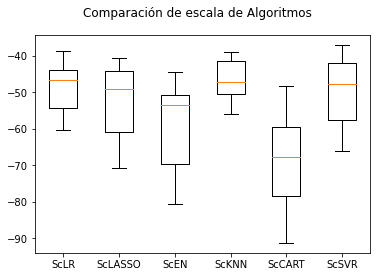

In [7]:
## d) Comparación los algoritmos, y escogemos el más preciso
fig = pyplot.figure()
fig.suptitle('Comparación de escala de Algoritmos')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

# Mejorar la precisión del algoritmo KNN

## a) Ajuste (tuning) del algoritmo
Sabemos por los resultados del paso previo que **KNN** logra buenos resultados en una versión escalada del conjunto de datos; lo que tenemos es que mejorarlo. 

El valor predeterminado para el número de vecinos en **KNN es 7**. En este caso podemos usar una **grid search** (búsqueda de cuadrícula) para probar un conjunto de diferentes números de vecinos y ver si podemos mejorar la puntuación (hiper-parámetros). 

El siguiente ejemplo prueba valores *k* impares de 1 a 21, un rango arbitrario que cubre un valor bueno conocido de 7. Cada valor *k* (**n_neighbors**) se evalúa utilizando una validación cruzada de 10 veces en una copia estandarizada del conjunto de datos de entrenamiento. 

Vamos a ver cómo el valos de *k=13* es el mejor de lejos (menor MSE).

In [8]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
k_values = numpy.array([1,3,5,7,9,11,13,15,17,19,21])
param_grid = dict(n_neighbors=k_values)
model = KNeighborsRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

print("Mejor: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Mejor: -44.077303 usando {'n_neighbors': 19}
-67.638662 (8.842135) with: {'n_neighbors': 1}
-48.258615 (6.892016) with: {'n_neighbors': 3}
-46.515158 (6.503066) with: {'n_neighbors': 5}
-46.446255 (7.234829) with: {'n_neighbors': 7}
-47.121529 (7.635679) with: {'n_neighbors': 9}
-45.471853 (7.517006) with: {'n_neighbors': 11}
-44.620545 (6.933070) with: {'n_neighbors': 13}
-44.100014 (6.029844) with: {'n_neighbors': 15}
-44.148401 (6.431632) with: {'n_neighbors': 17}
-44.077303 (6.431861) with: {'n_neighbors': 19}
-44.573473 (6.548805) with: {'n_neighbors': 21}


Como podemos observar el mejor resultado lo obtenemos para k=19.

## b) Ensembles (Conjuntos)

Recordamos de nuevo que otra forma para mejorar el rendimiento de los algoritmos es mediante el uso de métodos conjuntos o *ensembles*. Para ello vamos a evaluar 4 algoritmos de ML por conjuntos, 2 métodos de *boosting* o impulso y 2 de *bagging* o embolsado:

- **Métodos de *boosting* (impulso)**: AdaBoost (AB) y Gradient Boosting (GBM).
- **Métodos de *bagging* (embolsado)**: bosques aleatorios (RF) y árboles adicionales (ET).

Usaremos la misma selección de prueba que antes, 10-fold la validación cruzada y las pipelines que estandarizan los datos de entrenamiento para cada pliegue.

In [9]:
ensembles = []
ensembles.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostRegressor())])))
ensembles.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
ensembles.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor(n_estimators=100))])))
ensembles.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesRegressor(n_estimators=100))])))
results = []
names = []
for name, model in ensembles:
	kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

ScaledAB: -48.795767 (6.276561)
ScaledGBM: -42.198057 (10.084721)
ScaledRF: -41.222371 (8.199539)
ScaledET: -40.480507 (6.794715)


### Ajuste del ET escalado

El número que viene por defecto de etapas de *boosting* a realizar (n_estimators) es de 100. Este es un buen parámetro candidato para el ET. Sin embargo, en muchas ocasiones, **cuanto mayor sea el número de etapas, mejor será el rendimiento pero mayor será el tiempo de entrenamiento**. 

Hemos realizado un *grid search* sobre **n_estimators** de 50 a 400 con incrementos de 50 y verificamos cada configuración utilizando una validación cruzada de 10-folds.

In [13]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=numpy.array([50,100,150,200,250,300,350,400]))
model = ExtraTreesRegressor(random_state=seed)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

print("Mejor: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Mejor: -38.890895 usando {'n_estimators': 150}
-39.672541 (6.276669) with: {'n_estimators': 50}
-39.484866 (6.459622) with: {'n_estimators': 100}
-38.890895 (6.369268) with: {'n_estimators': 150}
-38.983734 (6.182982) with: {'n_estimators': 200}
-39.205402 (6.075446) with: {'n_estimators': 250}
-38.928160 (6.040052) with: {'n_estimators': 300}
-38.956167 (6.118281) with: {'n_estimators': 350}
-39.017633 (6.219410) with: {'n_estimators': 400}


**Podemos ver que la mejor configuración es con n_estimators=150, que nos da un MSE de -38.890895**.

# Finalizar el modelo
##  Predicciones sobre el conjunto de datos de validación


In [16]:
## Preparamos el modelo y lo entrenamos sobre el dataset completo de entrenamiento
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = ExtraTreesRegressor(random_state=seed, n_estimators=150)
model.fit(rescaledX, Y_train)

ExtraTreesRegressor(n_estimators=150, random_state=7)

In [17]:
### Transformamos el dataset de validación, con el escalado que trabajamos
rescaledValidationX = scaler.transform(X_validation)
predicciones = model.predict(rescaledValidationX)
print(mean_squared_error(Y_validation, predicciones))

30.711774657534246


**Nos sale un MSE cercano a nuestra estimación de -38.890895.**